## Robustness between donors

Compare DE effects predictions on different pairs of donors

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
from itertools import combinations

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
# from DE_analysis_utils import *

In [61]:
# # Add the parent directory to the path to import from sibling directory
# sys.path.append(os.path.abspath('../../1_preprocess/'))
# sys.path.append(os.path.abspath('../3_DE_analysis/'))
# sys.path.append(os.path.abspath('../'))
# from MultiStatePerturbSeqDataset import *

# def _run_DE_test(pbulk_adata, test_state = 'Rest'):
#     pbulk_adata.obs['log10_n_cells'] = np.log10(pbulk_adata.obs['n_cells'])

#     n_donors = pbulk_adata.obs['donor_id'].nunique()
#     if n_donors > 1:
#         design_formula = '~ log10_n_cells + donor_id + target'
#     else:
#         design_formula = '~ log10_n_cells + target'

#     # pbulk_adata = pbulk_adata[:, de_test_genes].copy()
#     min_counts_per_gene = 10
    
#     ms_perturb_data = MultistatePerturbSeqDataset(
#         pbulk_adata,
#         sample_cols = ['cell_sample_id'],
#         perturbation_type = 'CRISPRi',
#         target_col = 'perturbed_gene_id',
#         sgrna_col = 'guide_id',
#         state_col = 'culture_condition',
#         control_level = 'NTC'
#         )

#     results = ms_perturb_data.run_target_DE(
#         design_formula = design_formula,
#         test_state = [test_state],
#         min_counts_per_gene = min_counts_per_gene,
#         return_model = False,
#         n_cpus=3
#         )

#     n_cells_target = ms_perturb_data.adata.obs.groupby('target')['n_cells'].sum().reset_index()
#     results = pd.merge(results.rename({'contrast':'target'}, axis=1), n_cells_target)
#     results['n_donors'] = n_donors
#     results['donors'] = '_'.join(pbulk_adata.obs['donor_id'].unique().tolist())
#     results['signif'] = results['adj_p_value'] < 0.1
#     return(results)

In [62]:
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

In [63]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
results_dir = datadir + 'donor_robustness_analysis/'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [64]:
os.listdir(results_dir)

['DE_donor_robustness.ENSG00000086730.parquet',
 'DE_donor_robustness.ENSG00000164466_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000102038_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000071655_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000178403_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000117640_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000023287_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000173757_Rest.parquet',
 'DE_donor_robustness.ENSG00000154832_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000052841_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000092531_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000170545_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000159079_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000163600.parquet',
 'DE_donor_robustness.ENSG00000109220_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000197183_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000116128_Stim8hr.parquet',
 'DE_donor_robustness.ENSG00000008838_Stim8hr.parquet',
 'DE_donor_

In [57]:
adata_de

AnnData object with n_obs × n_vars = 33986 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value'

In [69]:
de_counts = pd.read_csv(f'{datadir}/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)

In [70]:
de_counts

target_contrast target_name condition  n_cells_target  n_up_genes  \
0      ENSG00000012963        UBR7   Stim8hr           491.0           0   
1      ENSG00000017260      ATP2C1   Stim8hr           469.0           0   
2      ENSG00000067606       PRKCZ   Stim8hr           427.0           1   
3      ENSG00000092929      UNC13D   Stim8hr           830.0           0   
4      ENSG00000100504        PYGL   Stim8hr           414.0           1   
...                ...         ...       ...             ...         ...   
33981  ENSG00000198342      ZNF442      Rest           324.0           0   
33982  ENSG00000205572      SERF1B      Rest            44.0           7   
33983  ENSG00000221890       NPTXR      Rest           293.0           0   
33984  ENSG00000236320      SLFN14      Rest           848.0           0   
33985  ENSG00000246705       H2AFJ      Rest          1173.0           2   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
0                 2                 2            -12.952742   
1                 1                 1            -16.307246   
2                 1                 2             -1.658755   
3                 2                 2            -19.259466   
4                 0                 1                   NaN   
...             ...               ...                   ...   
33981             0                 0                   NaN   
33982            24                31                   NaN   
33983             3                 3             -1.027171   
33984             0                 0                   NaN   
33985             2                 4            -18.574962   

       ontarget_significant    baseMean  offtarget_flag  \
0                      True   43.169196            True   
1                      True  102.399025           False   
2                     False    0.965897           False   
3                      True   60.904483           False   
4                     False         NaN           False   
...                     ...         ...             ...   
33981                 False         NaN           False   
33982                 False         NaN           False   
33983                 False    0.798092           False   
33984                 False         NaN           False   
33985                  True   42.729358            True   

      n_total_genes_category ontarget_effect_category  
0              2-10 DE genes             on-target KD  
1                  1 DE gene             on-target KD  
2              2-10 DE genes          no on-target KD  
3              2-10 DE genes             on-target KD  
4                  1 DE gene          no on-target KD  
...                      ...                      ...  
33981              no effect          no on-target KD  
33982           >10 DE genes          no on-target KD  
33983          2-10 DE genes          no on-target KD  
33984              no effect          no on-target KD  
33985          2-10 DE genes             on-target KD  

[33986 rows x 13 columns]

## Example

Read outputs of `get_donor_robustness.py`

In [7]:
cond = 'Rest'
parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*.parquet")
all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
all_results_df = all_results_df[all_results_df['culture_condition'] == cond]

### Compute correlation of DE effects

In [9]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='zscore')
pivoted_signif = all_results_df.pivot(columns='donors', index=['target','variable'], values='signif')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_signif = pivoted_signif.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            corr = target_data[pair[0]].corr(target_data[pair[1]])
            # F1 score calculation for this target and this pair
            gs_signif = set(target_signif[target_signif[pair[0]] == 1].index)
            test_signif = set(target_signif[target_signif[pair[1]] == 1].index)
            tp = len(gs_signif & test_signif)
            fp = len(test_signif - gs_signif)
            fn = len(gs_signif - test_signif)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'f1': f1
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
correlations

target_contrast               donors             variable  correlation  \
0   ENSG00000102908  CE0008678_CE0010866  CE0008162_CE0006864     0.390608   
1   ENSG00000102908  CE0008678_CE0008162  CE0010866_CE0006864     0.522647   
2   ENSG00000102908  CE0008678_CE0006864  CE0010866_CE0008162     0.536297   
3   ENSG00000102908  CE0008678_CE0010866  CE0008162_CE0006864     0.390608   
4   ENSG00000102908  CE0008678_CE0008162  CE0010866_CE0006864     0.522647   
5   ENSG00000102908  CE0008678_CE0006864  CE0010866_CE0008162     0.536297   
6   ENSG00000134460  CE0008678_CE0010866  CE0008162_CE0006864     0.064495   
7   ENSG00000134460  CE0008678_CE0008162  CE0010866_CE0006864     0.120532   
8   ENSG00000134460  CE0008678_CE0006864  CE0010866_CE0008162     0.036326   
9   ENSG00000134460  CE0008678_CE0010866  CE0008162_CE0006864     0.064495   
10  ENSG00000134460  CE0008678_CE0008162  CE0010866_CE0006864     0.120532   
11  ENSG00000134460  CE0008678_CE0006864  CE0010866_CE0008162     0.036326   
12  ENSG00000173757  CE0008678_CE0010866  CE0008162_CE0006864     0.334253   
13  ENSG00000173757  CE0008678_CE0008162  CE0010866_CE0006864     0.315282   
14  ENSG00000173757  CE0008678_CE0006864  CE0010866_CE0008162     0.332079   
15  ENSG00000173757  CE0008678_CE0010866  CE0008162_CE0006864     0.334253   
16  ENSG00000173757  CE0008678_CE0008162  CE0010866_CE0006864     0.315282   
17  ENSG00000173757  CE0008678_CE0006864  CE0010866_CE0008162     0.332079   

          f1 target_name condition  n_cells_target  n_up_genes  n_down_genes  \
0   0.001723       NFAT5      Rest           394.0         901           723   
1   0.001053       NFAT5      Rest           394.0         901           723   
2   0.311828       NFAT5      Rest           394.0         901           723   
3   0.001723       NFAT5      Rest           394.0         901           723   
4   0.001053       NFAT5      Rest           394.0         901           723   
5   0.311828       NFAT5      Rest           394.0         901           723   
6   0.000000       IL2RA      Rest           237.0           5             5   
7   0.000000       IL2RA      Rest           237.0           5             5   
8   0.083333       IL2RA      Rest           237.0           5             5   
9   0.000000       IL2RA      Rest           237.0           5             5   
10  0.000000       IL2RA      Rest           237.0           5             5   
11  0.083333       IL2RA      Rest           237.0           5             5   
12  0.224157      STAT5B      Rest           110.0         652           483   
13  0.158131      STAT5B      Rest           110.0         652           483   
14  0.223028      STAT5B      Rest           110.0         652           483   
15  0.224157      STAT5B      Rest           110.0         652           483   
16  0.158131      STAT5B      Rest           110.0         652           483   
17  0.223028      STAT5B      Rest           110.0         652           483   

    n_total_de_genes  ontarget_effect_size  ontarget_significant   baseMean  \
0               1624             -9.675924                  True  30.278524   
1               1624             -9.675924                  True  30.278524   
2               1624             -9.675924                  True  30.278524   
3               1624             -9.675924                  True  30.278524   
4               1624             -9.675924                  True  30.278524   
5               1624             -9.675924                  True  30.278524   
6                 10             -6.938083                  True  76.319301   
7                 10             -6.938083                  True  76.319301   
8                 10             -6.938083                  True  76.319301   
9                 10             -6.938083                  True  76.319301   
10                10             -6.938083                  True  76.319301   
11                10             -6.938083          

<Axes: xlabel='target_name', ylabel='correlation'>

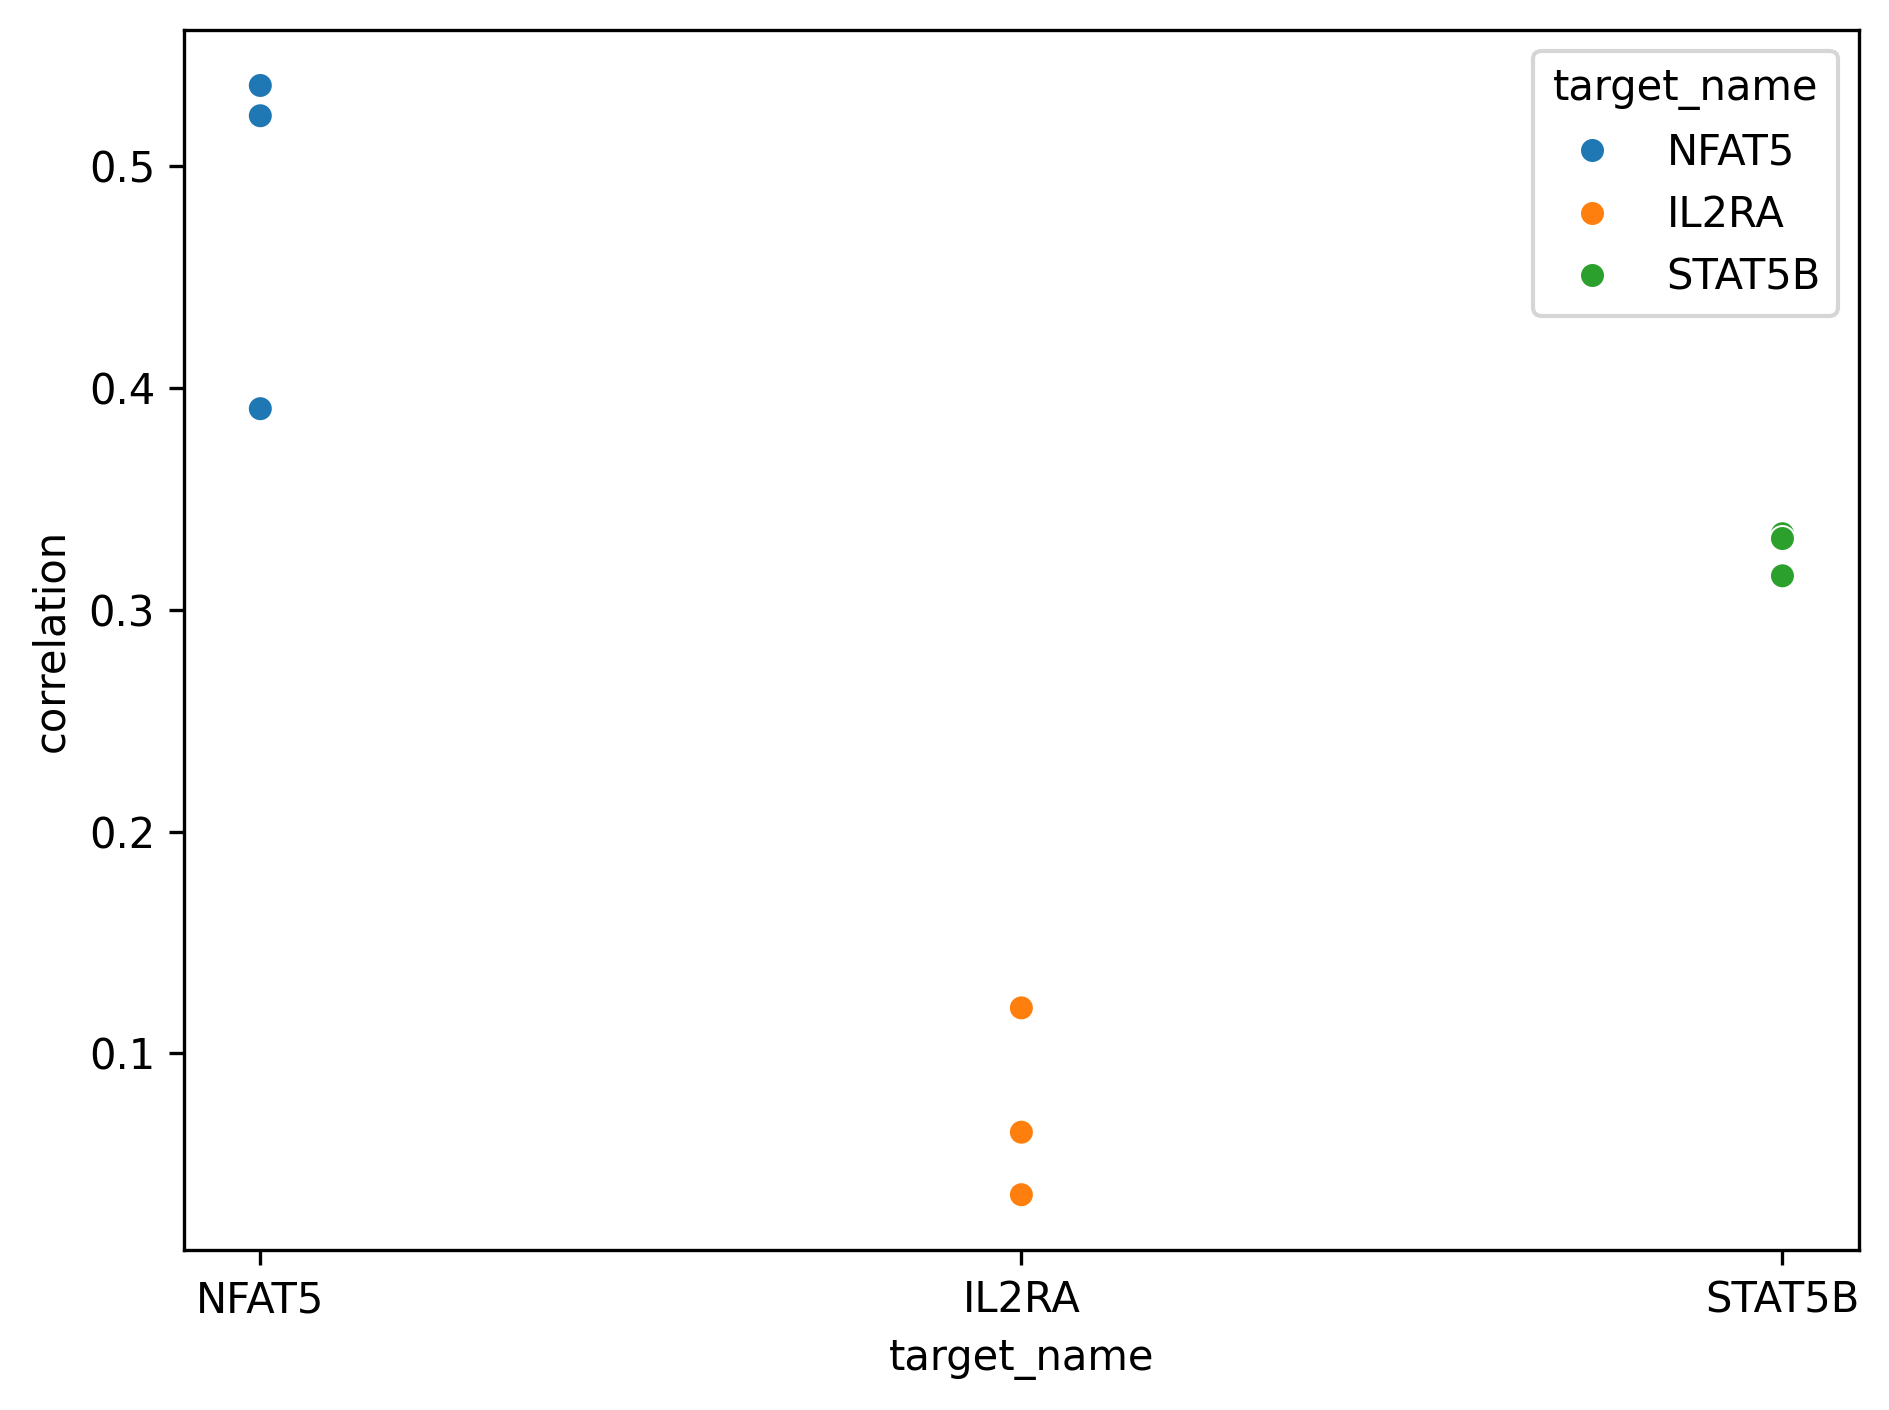

In [10]:
sns.scatterplot(data=correlations, x='target_name', y='correlation', hue='target_name')

In [80]:
all_results_df[(all_results_df['target'] == 'ENSG00000163600') & (all_results_df['signif'])].pivot(columns='donors', values='zscore', index='variable')

donors           CE0006864_CE0008162  CE0006864_CE0008678  \
variable                                                    
ENSG00000001561                  NaN                  NaN   
ENSG00000002586                  NaN                  NaN   
ENSG00000002919                  NaN                  NaN   
ENSG00000003147                  NaN                  NaN   
ENSG00000003509                  NaN                  NaN   
...                              ...                  ...   
ENSG00000276070                  NaN                  NaN   
ENSG00000277632                  NaN                  NaN   
ENSG00000285077                  NaN                  NaN   
ENSG00000291122                  NaN                  NaN   
ENSG00000291237                  NaN                  NaN   

donors           CE0006864_CE0010866  CE0008162_CE0008678  \
variable                                                    
ENSG00000001561             3.711157                  NaN   
ENSG00000002586             3.220100                  NaN   
ENSG00000002919                  NaN                  NaN   
ENSG00000003147             2.943739                  NaN   
ENSG00000003509             3.827682                  NaN   
...                              ...                  ...   
ENSG00000276070             3.785309                  NaN   
ENSG00000277632             4.488954                  NaN   
ENSG00000285077                  NaN                  NaN   
ENSG00000291122             3.894900                  NaN   
ENSG00000291237                  NaN                  NaN   

donors           CE0008162_CE0010866  CE0010866_CE0008678  
variable                                                   
ENSG00000001561             2.660844             3.047771  
ENSG00000002586             3.410015             3.723671  
ENSG00000002919             2.670441                  NaN  
ENSG00000003147             2.976174             2.877833  
ENSG00000003509             2.639401                  NaN  
...                              ...                  ...  
ENSG00000276070             3.514623             4.617196  
ENSG00000277632             4.519845             4.268687  
ENSG00000285077             3.372393                  NaN  
ENSG00000291122             4.989487             4.445927  
ENSG00000291237            -3.004321                  NaN  

[1203 rows x 6 columns]

Text(0, 0.5, 'CE0008162_CE0010866')

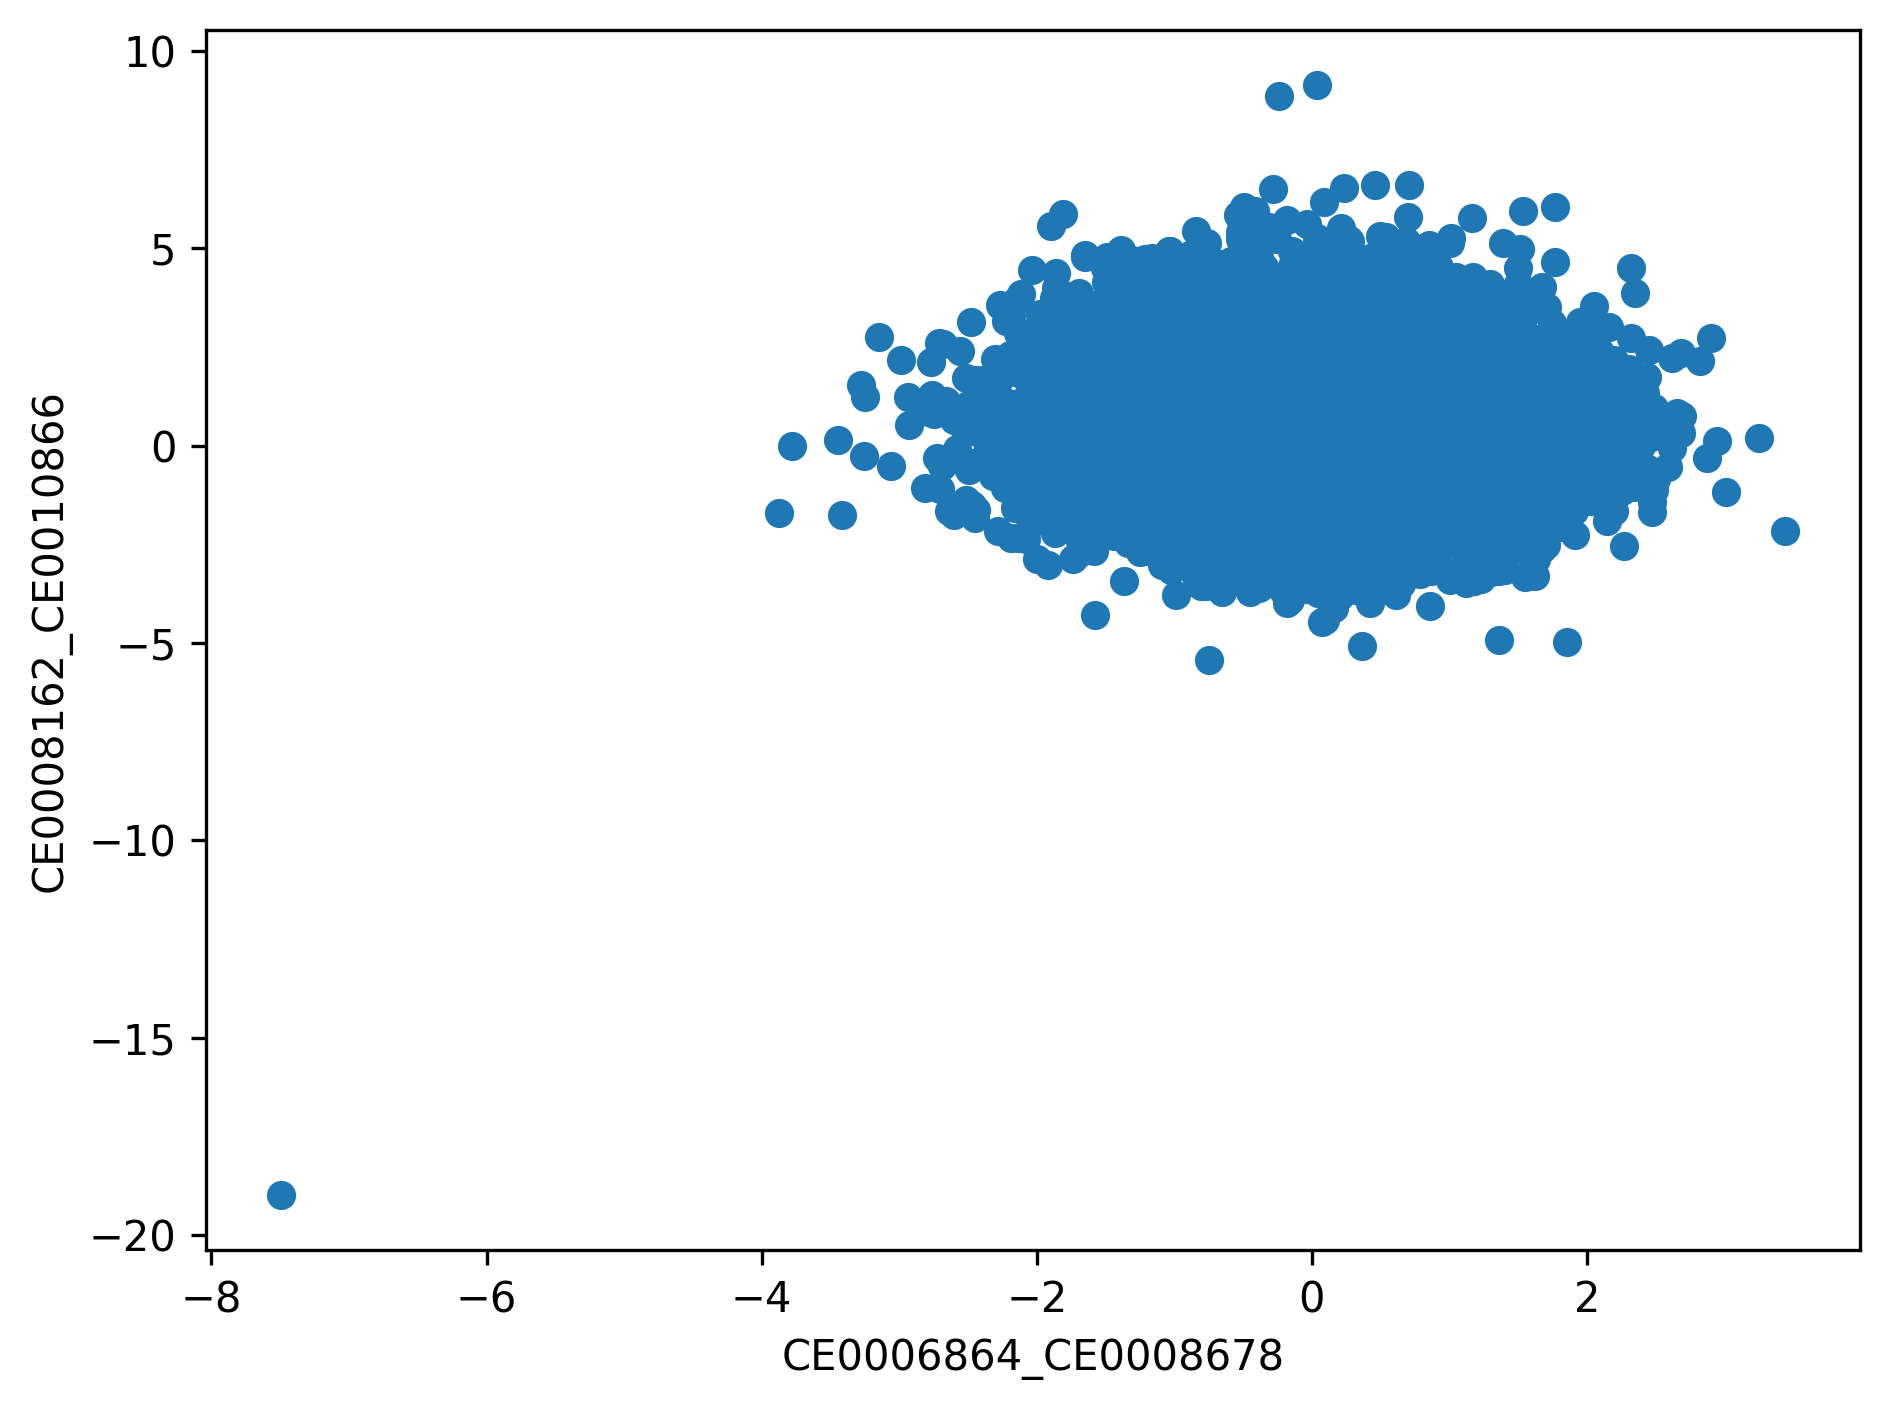

In [75]:
pl_df = all_results_df[all_results_df['target'] == 'ENSG00000163600'].pivot(columns='donors', values='zscore', index='variable')

pair_ix = 2
plt.scatter(pl_df[comparison_pairs[pair_ix][0]], pl_df[comparison_pairs[pair_ix][1]])
plt.xlabel(comparison_pairs[pair_ix][0])
plt.ylabel(comparison_pairs[pair_ix][1])

In [8]:
from DE_analysis_utils import *

In [10]:
selected_perturbed_genes = ['IL2RA']
pbulk_adata = anndata.experimental.read_lazy('/mnt/oak/users/emma/data/GWT/CD4i_final/CD4i_final_merged.DE_pseudobulk.h5ad')
pbulk_adata_test = pbulk_adata[pbulk_adata.obs['perturbed_gene_name'].isin(selected_perturbed_genes + ['NTC'])].to_memory()
# pbulk_adata_test = pbulk_adata_test[pbulk_adata_test.obs['culture_condition'] == cond].copy()
sc.pp.normalize_total(pbulk_adata_test)
sc.pp.log1p(pbulk_adata_test)

<Axes: title={'center': 'IL2RA expression by IL2RA vs NTC in Stim48hr'}, xlabel='perturbed_gene_name', ylabel='IL2RA expression'>

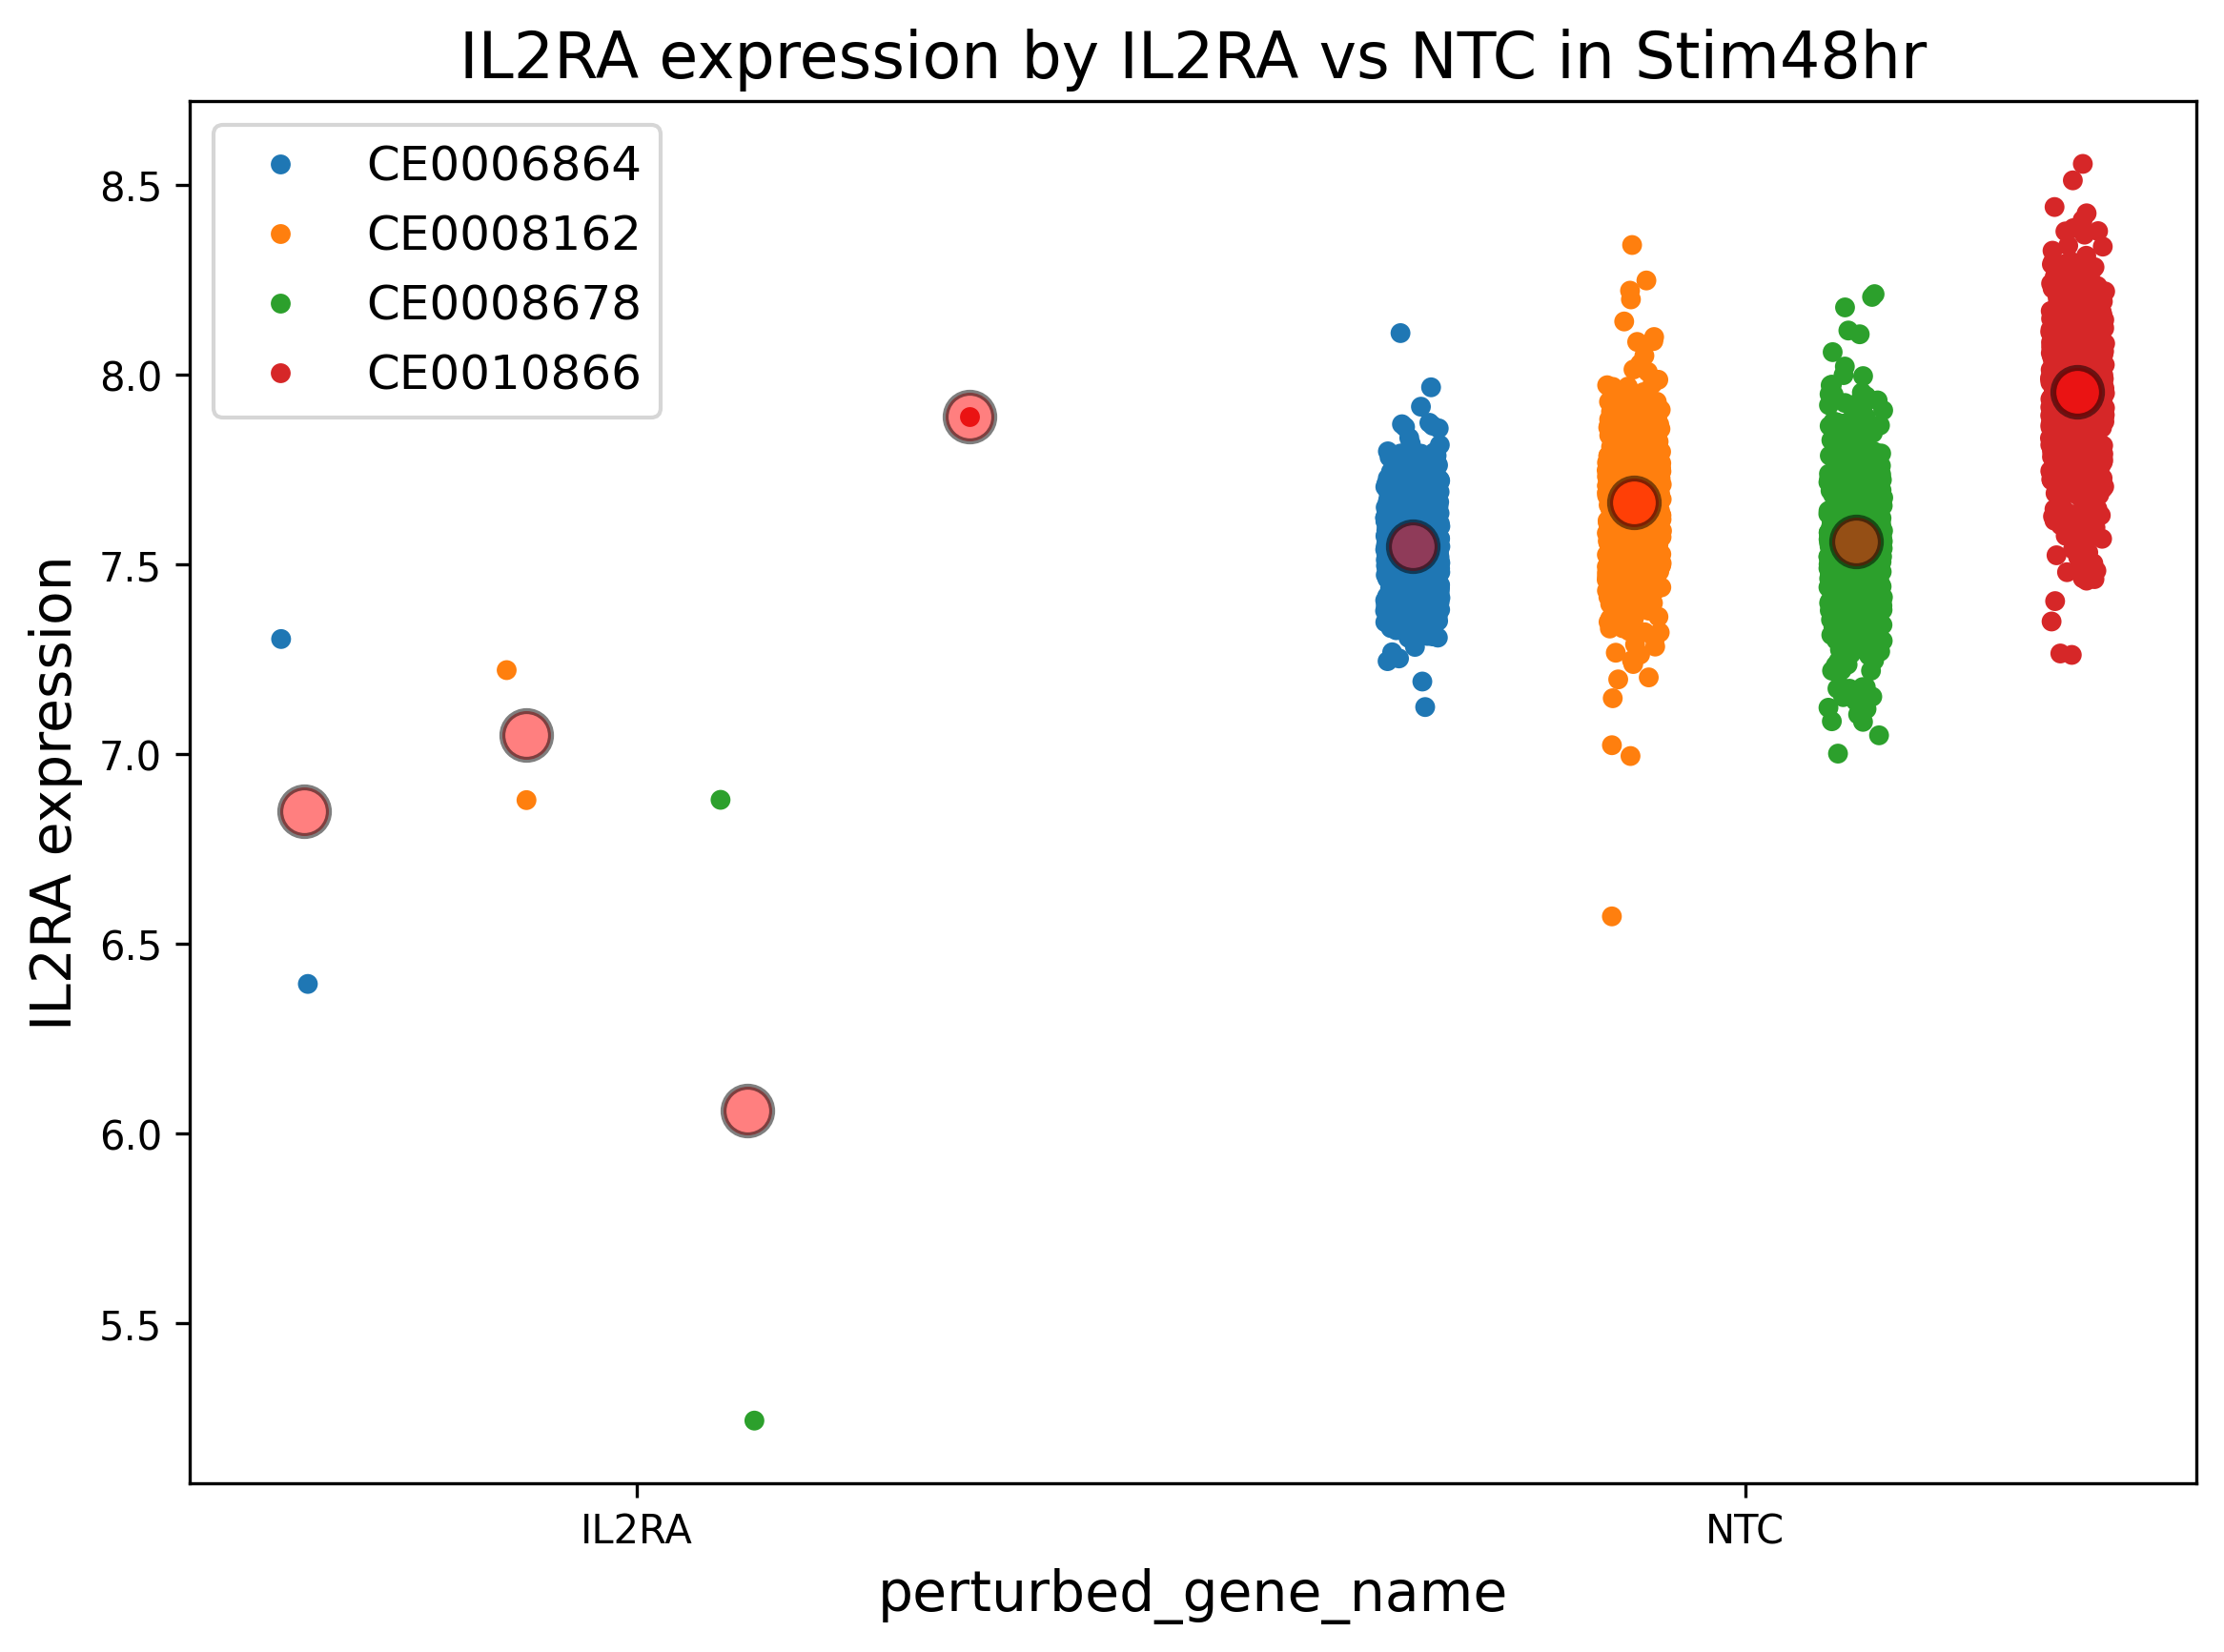

In [11]:
plot_gene_expression_by_target(pbulk_adata_test, 'IL2RA', 'IL2RA', condition='Stim48hr', hue='donor_id',
                                  target_name_col='perturbed_gene_name', gene_name_col='gene_name')



## Th2 regulators

Using list curated by Ron

```bash
PERTURBS=$(tr '\n' ',' < th2regulators.txt | sed 's/,$//')
python get_donor_robustness.py --condition Stim8hr --target $PERTURBS
```

Read outputs of `get_donor_robustness.py`

In [11]:
cond = 'Stim8hr'
Th2_regulators = pd.read_table('th2regulators.txt', header=None)[0].tolist()

parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*.parquet")
all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
all_results_df = all_results_df[all_results_df['culture_condition'] == cond]
all_results_df

variable    baseMean    log_fc     lfcSE      stat   p_value  \
0        ENSG00000135829  200.469956  0.220522  0.057391  3.842479  0.000122   
1        ENSG00000105618  180.605080  0.213724  0.055884  3.824427  0.000131   
2        ENSG00000141905    9.420225  0.783465  0.211871  3.697845  0.000217   
3        ENSG00000107077   41.793312  0.391626  0.107818  3.632295  0.000281   
4        ENSG00000090372   62.520677  0.309093  0.085245  3.625948  0.000288   
...                  ...         ...       ...       ...       ...       ...   
2516523  ENSG00000158691    3.767356  0.000092  0.329593  0.000278  0.999778   
2516524  ENSG00000089723    2.580450  0.000141  0.607739  0.000232  0.999815   
2516525  ENSG00000141030  106.620820 -0.000004  0.073777 -0.000059  0.999953   
2516526  ENSG00000112115    1.868006 -1.741139  3.178153 -0.547846       NaN   
2516527  ENSG00000112116    5.843813 -2.197126  2.583277 -0.850519       NaN   

         adj_p_value           target culture_condition  n_cells  n_donors  \
0           0.683430  ENSG00000086730           Stim8hr    242.0         2   
1           0.683430  ENSG00000086730           Stim8hr    242.0         2   
2           0.683430  ENSG00000086730           Stim8hr    242.0         2   
3           0.683430  ENSG00000086730           Stim8hr    242.0         2   
4           0.683430  ENSG00000086730           Stim8hr    242.0         2   
...              ...              ...               ...      ...       ...   
2516523     0.999909  ENSG00000015285           Stim8hr    289.0         2   
2516524     0.999909  ENSG00000015285           Stim8hr    289.0         2   
2516525     0.999953  ENSG00000015285           Stim8hr    289.0         2   
2516526          NaN  ENSG00000015285           Stim8hr    289.0         2   
2516527          NaN  ENSG00000015285           Stim8hr    289.0         2   

                      donors  signif    zscore  
0        CE0006864_CE0008162   False  3.842479  
1        CE0006864_CE0008162   False  3.824427  
2        CE0006864_CE0008162   False  3.697845  
3        CE0006864_CE0008162   False  3.632295  
4        CE0006864_CE0008162   False  3.625948  
...                      ...     ...       ...  
2516523  CE0010866_CE0008678   False  0.000278  
2516524  CE0010866_CE0008678   False  0.000232  
2516525  CE0010866_CE0008678   False -0.000059  
2516526  CE0010866_CE0008678   False -0.547846  
2516527  CE0010866_CE0008678   False -0.850519  

[2258843 rows x 14 columns]


### Compute correlation of DE effects

In [14]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil


In [15]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='log_fc')
pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_se = pivoted_se.loc[target]
    target_p = pivoted_pval.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            # Get mask for genes with p < 0.1 in either test
            sig_mask = (target_p[pair[0]] < 0.2) | (target_p[pair[1]] < 0.2)
            # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
            
            # Filter data using mask
            data1 = target_data[pair[0]][sig_mask]
            data2 = target_data[pair[1]][sig_mask]
            se1 = target_se[pair[0]][sig_mask]
            se2 = target_se[pair[1]][sig_mask]
            
            corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'correlation_ceiling': corr_ceil,
                'n_signif':data1.shape[0]
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
# correlations = correlations[correlations.target_name.isin(Th2_regulators)]

/tmp/ipykernel_2251812/2298880084.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


NameError: name 'de_counts' is not defined

In [12]:
correlations

NameError: name 'correlations' is not defined

/tmp/ipykernel_4020663/3072865098.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


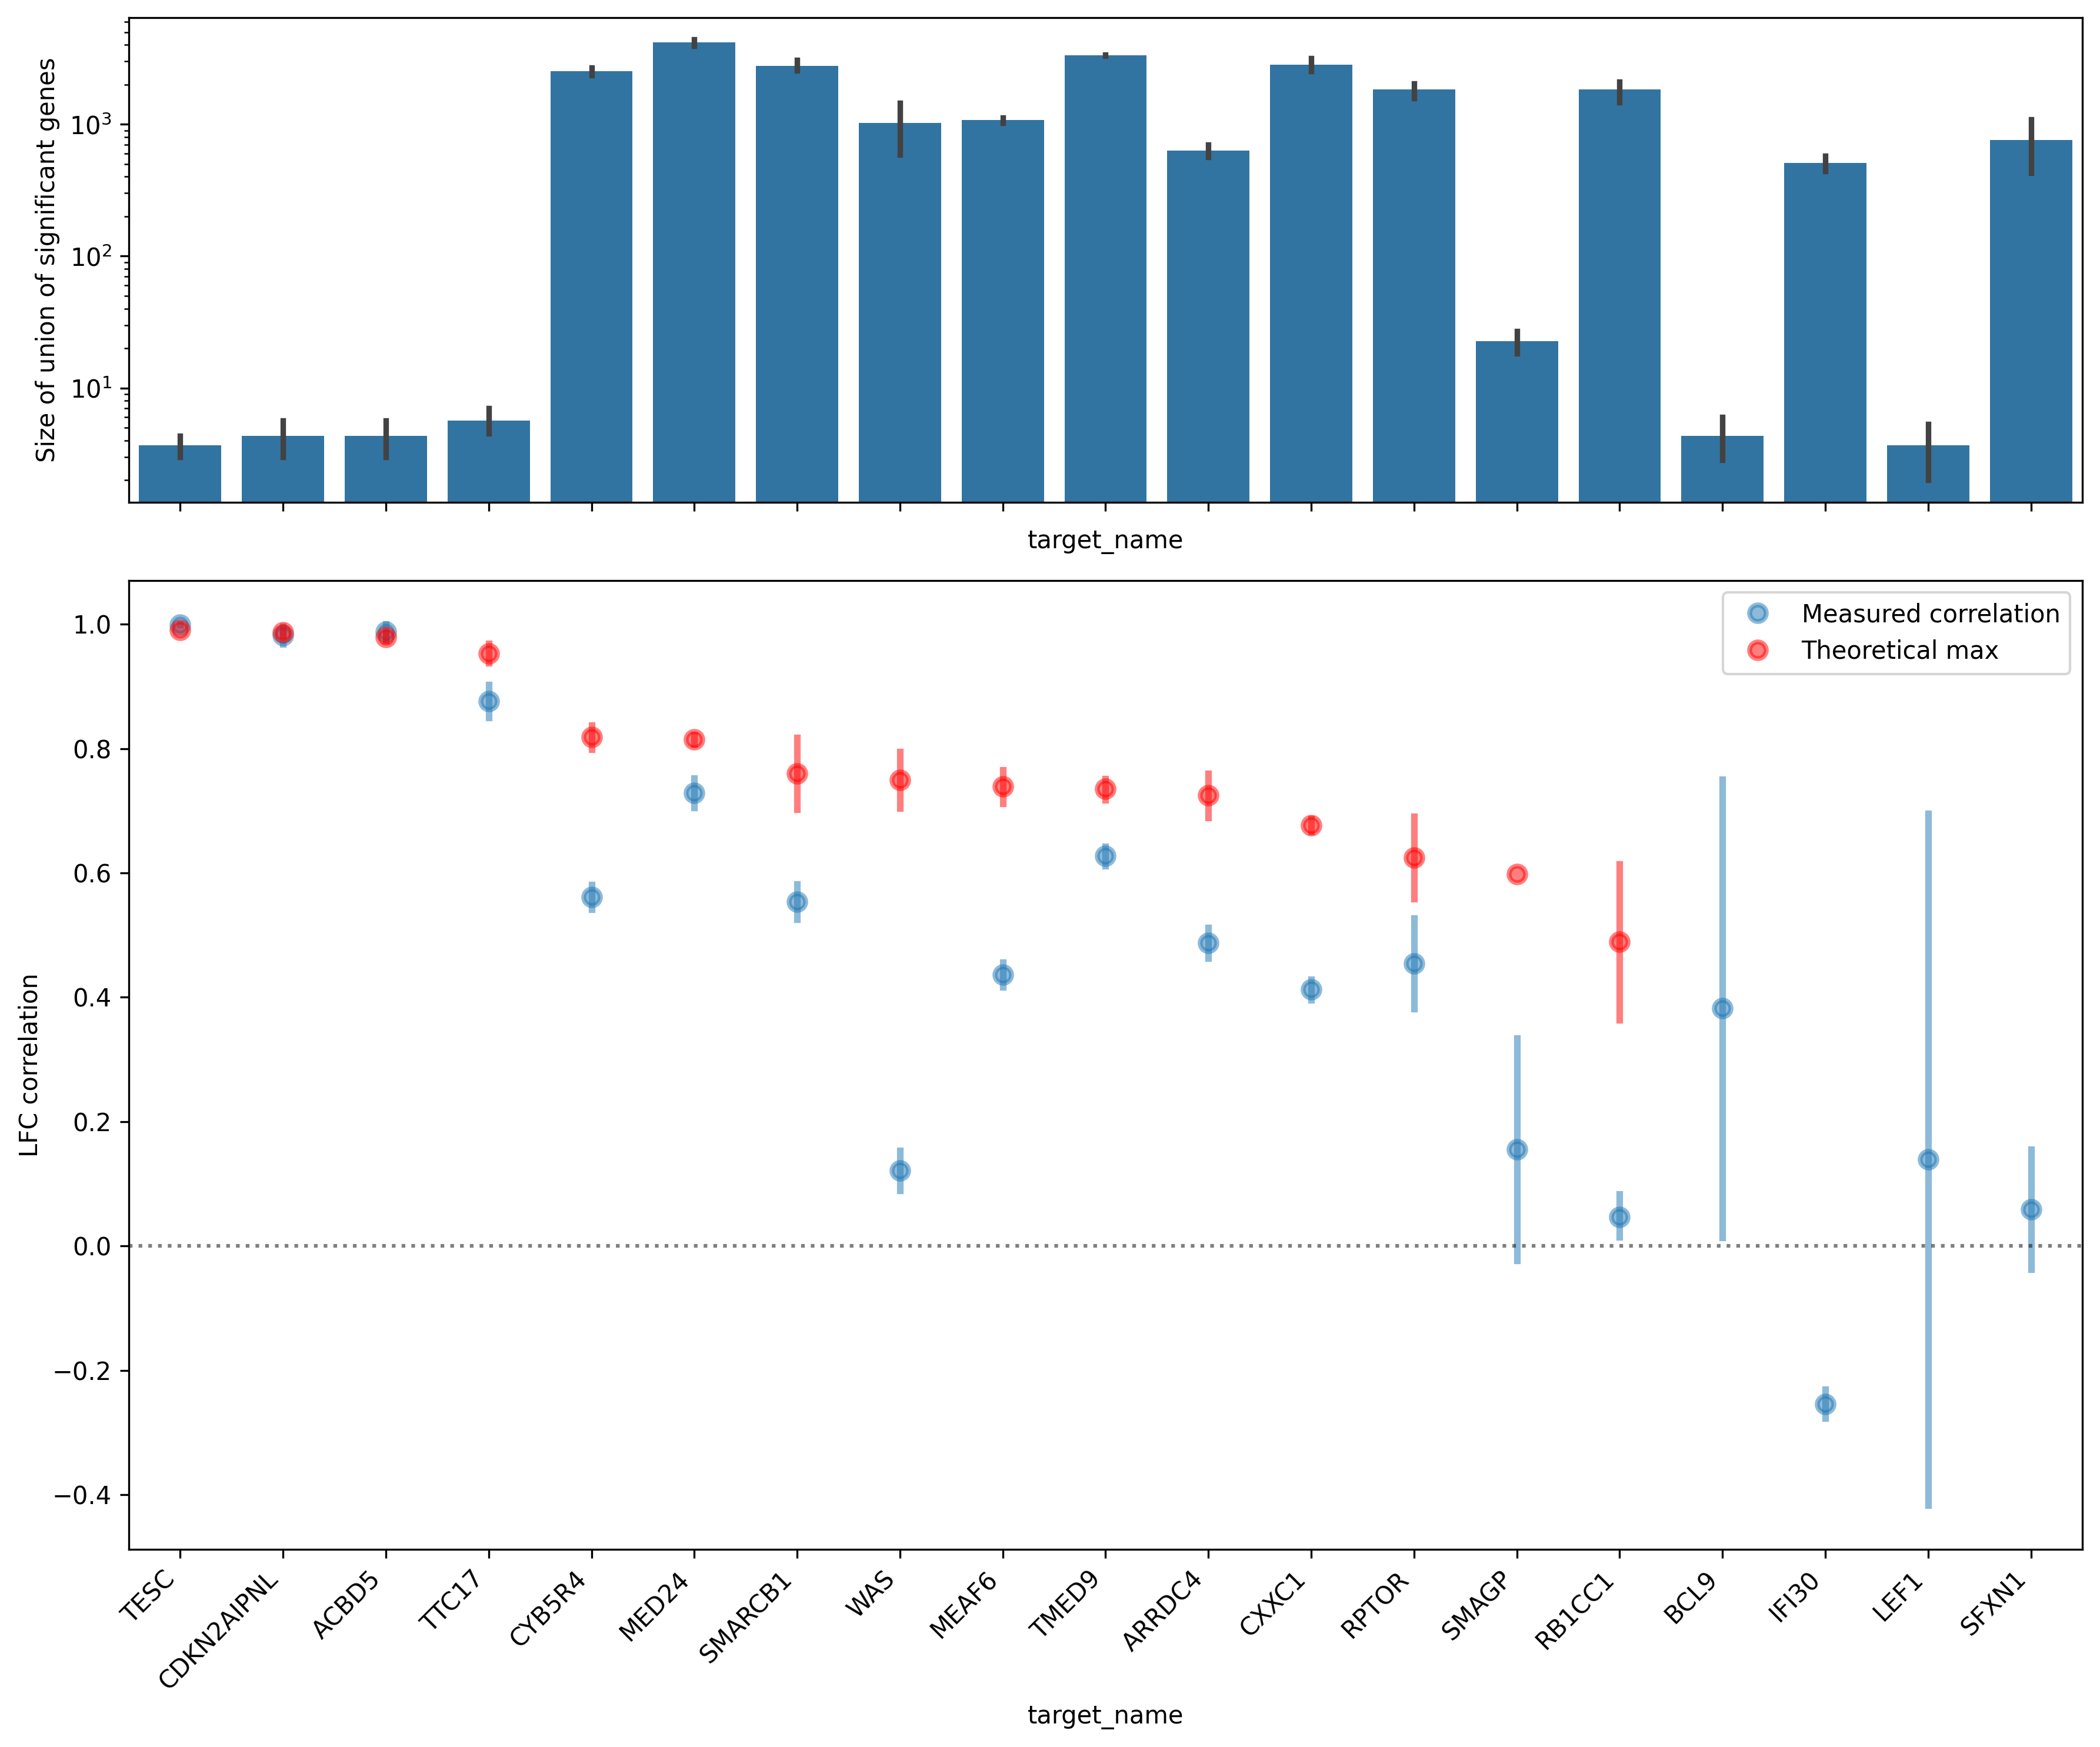

In [53]:
# Calculate mean correlation per target to sort by
mean_corr = correlations.groupby('target_name')['correlation_ceiling'].mean().sort_values(ascending=False)
sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='', label='Measured correlation')
sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
              order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='', label='Theoretical max')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)
ax2.set_ylabel('LFC correlation')
# Add legend inside plot
ax2.legend(bbox_to_anchor=(1, 1))


# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [41]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='zscore')
pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_se = pivoted_se.loc[target]
    target_p = pivoted_pval.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            # Get mask for genes with p < 0.1 in either test
            sig_mask = (target_p[pair[0]] < 0.2) | (target_p[pair[1]] < 0.2)
            # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
            
            # Filter data using mask
            data1 = target_data[pair[0]][sig_mask]
            data2 = target_data[pair[1]][sig_mask]
            se1 = target_se[pair[0]][sig_mask]
            se2 = target_se[pair[1]][sig_mask]
            
            corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'correlation_ceiling': corr_ceil,
                'n_signif':data1.shape[0]
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
correlations

/tmp/ipykernel_4020663/2298880084.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


target_contrast               donors             variable  correlation  \
0    ENSG00000008838  CE0006864_CE0008162  CE0010866_CE0008678     0.681650   
1    ENSG00000008838  CE0006864_CE0010866  CE0008162_CE0008678     0.755650   
2    ENSG00000008838  CE0006864_CE0008678  CE0008162_CE0010866     0.750722   
3    ENSG00000008838  CE0006864_CE0008162  CE0010866_CE0008678     0.681650   
4    ENSG00000008838  CE0006864_CE0010866  CE0008162_CE0008678     0.755650   
..               ...                  ...                  ...          ...   
151  ENSG00000237190  CE0006864_CE0010866  CE0008162_CE0008678     0.958194   
152  ENSG00000237190  CE0006864_CE0008678  CE0008162_CE0010866     1.000000   
153  ENSG00000237190  CE0006864_CE0008162  CE0010866_CE0008678     0.801163   
154  ENSG00000237190  CE0006864_CE0010866  CE0008162_CE0008678     0.958194   
155  ENSG00000237190  CE0006864_CE0008678  CE0008162_CE0010866     1.000000   

     correlation_ceiling  n_signif target_name condition  n_cells_target  \
0               0.988327      4244       MED24   Stim8hr           700.0   
1               0.988882      4507       MED24   Stim8hr           700.0   
2               0.990104      3752       MED24   Stim8hr           700.0   
3               0.988327      4244       MED24   Stim8hr           700.0   
4               0.988882      4507       MED24   Stim8hr           700.0   
..                   ...       ...         ...       ...             ...   
151             0.996624         6  CDKN2AIPNL   Stim8hr           820.0   
152             0.999442         2  CDKN2AIPNL   Stim8hr           820.0   
153             0.999089         5  CDKN2AIPNL   Stim8hr           820.0   
154             0.996624         6  CDKN2AIPNL   Stim8hr           820.0   
155             0.999442         2  CDKN2AIPNL   Stim8hr           820.0   

     n_up_genes  n_down_genes  n_total_de_genes  ontarget_effect_size  \
0        1139.0        1656.0            2795.0            -22.112543   
1        1139.0        1656.0            2795.0            -22.112543   
2        1139.0        1656.0            2795.0            -22.112543   
3        1139.0        1656.0            2795.0            -22.112543   
4        1139.0        1656.0            2795.0            -22.112543   
..          ...           ...               ...                   ...   
151         1.0           1.0               2.0            -16.296365   
152         1.0           1.0               2.0            -16.296365   
153         1.0           1.0               2.0            -16.296365   
154         1.0           1.0               2.0            -16.296365   
155         1.0           1.0               2.0            -16.296365   

    ontarget_significant   baseMean offtarget_flag n_total_genes_category  \
0                   True  87.435833           True           >10 DE genes   
1                   True  87.435833           True           >10 DE genes   
2                   True  87.435833           True           >10 DE genes   
3                   True  87.435833           True           >10 DE genes   
4                   True  87.435833           True           >10 DE genes   
..                   ...        ...            ...                    ...   
151                 True  32.377350          False          2-10 DE genes   
152                 True  32.377350          False          2-10 DE genes   
153                 True  32.377350          False          2-10 DE genes   
154                 True  32.377350          False          2-10 DE genes   
155                 True  32.377350          False          2-10 DE genes   

    ontarget_effect_category  
0               on-target KD  
1               on-target KD  
2               on-target KD  
3               on-target KD  
4               on-target KD  
..                       ...  
151             on-target KD  
152             on-target KD  
153             on-target KD  
154             on-target KD  


/tmp/ipykernel_4020663/1803697279.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


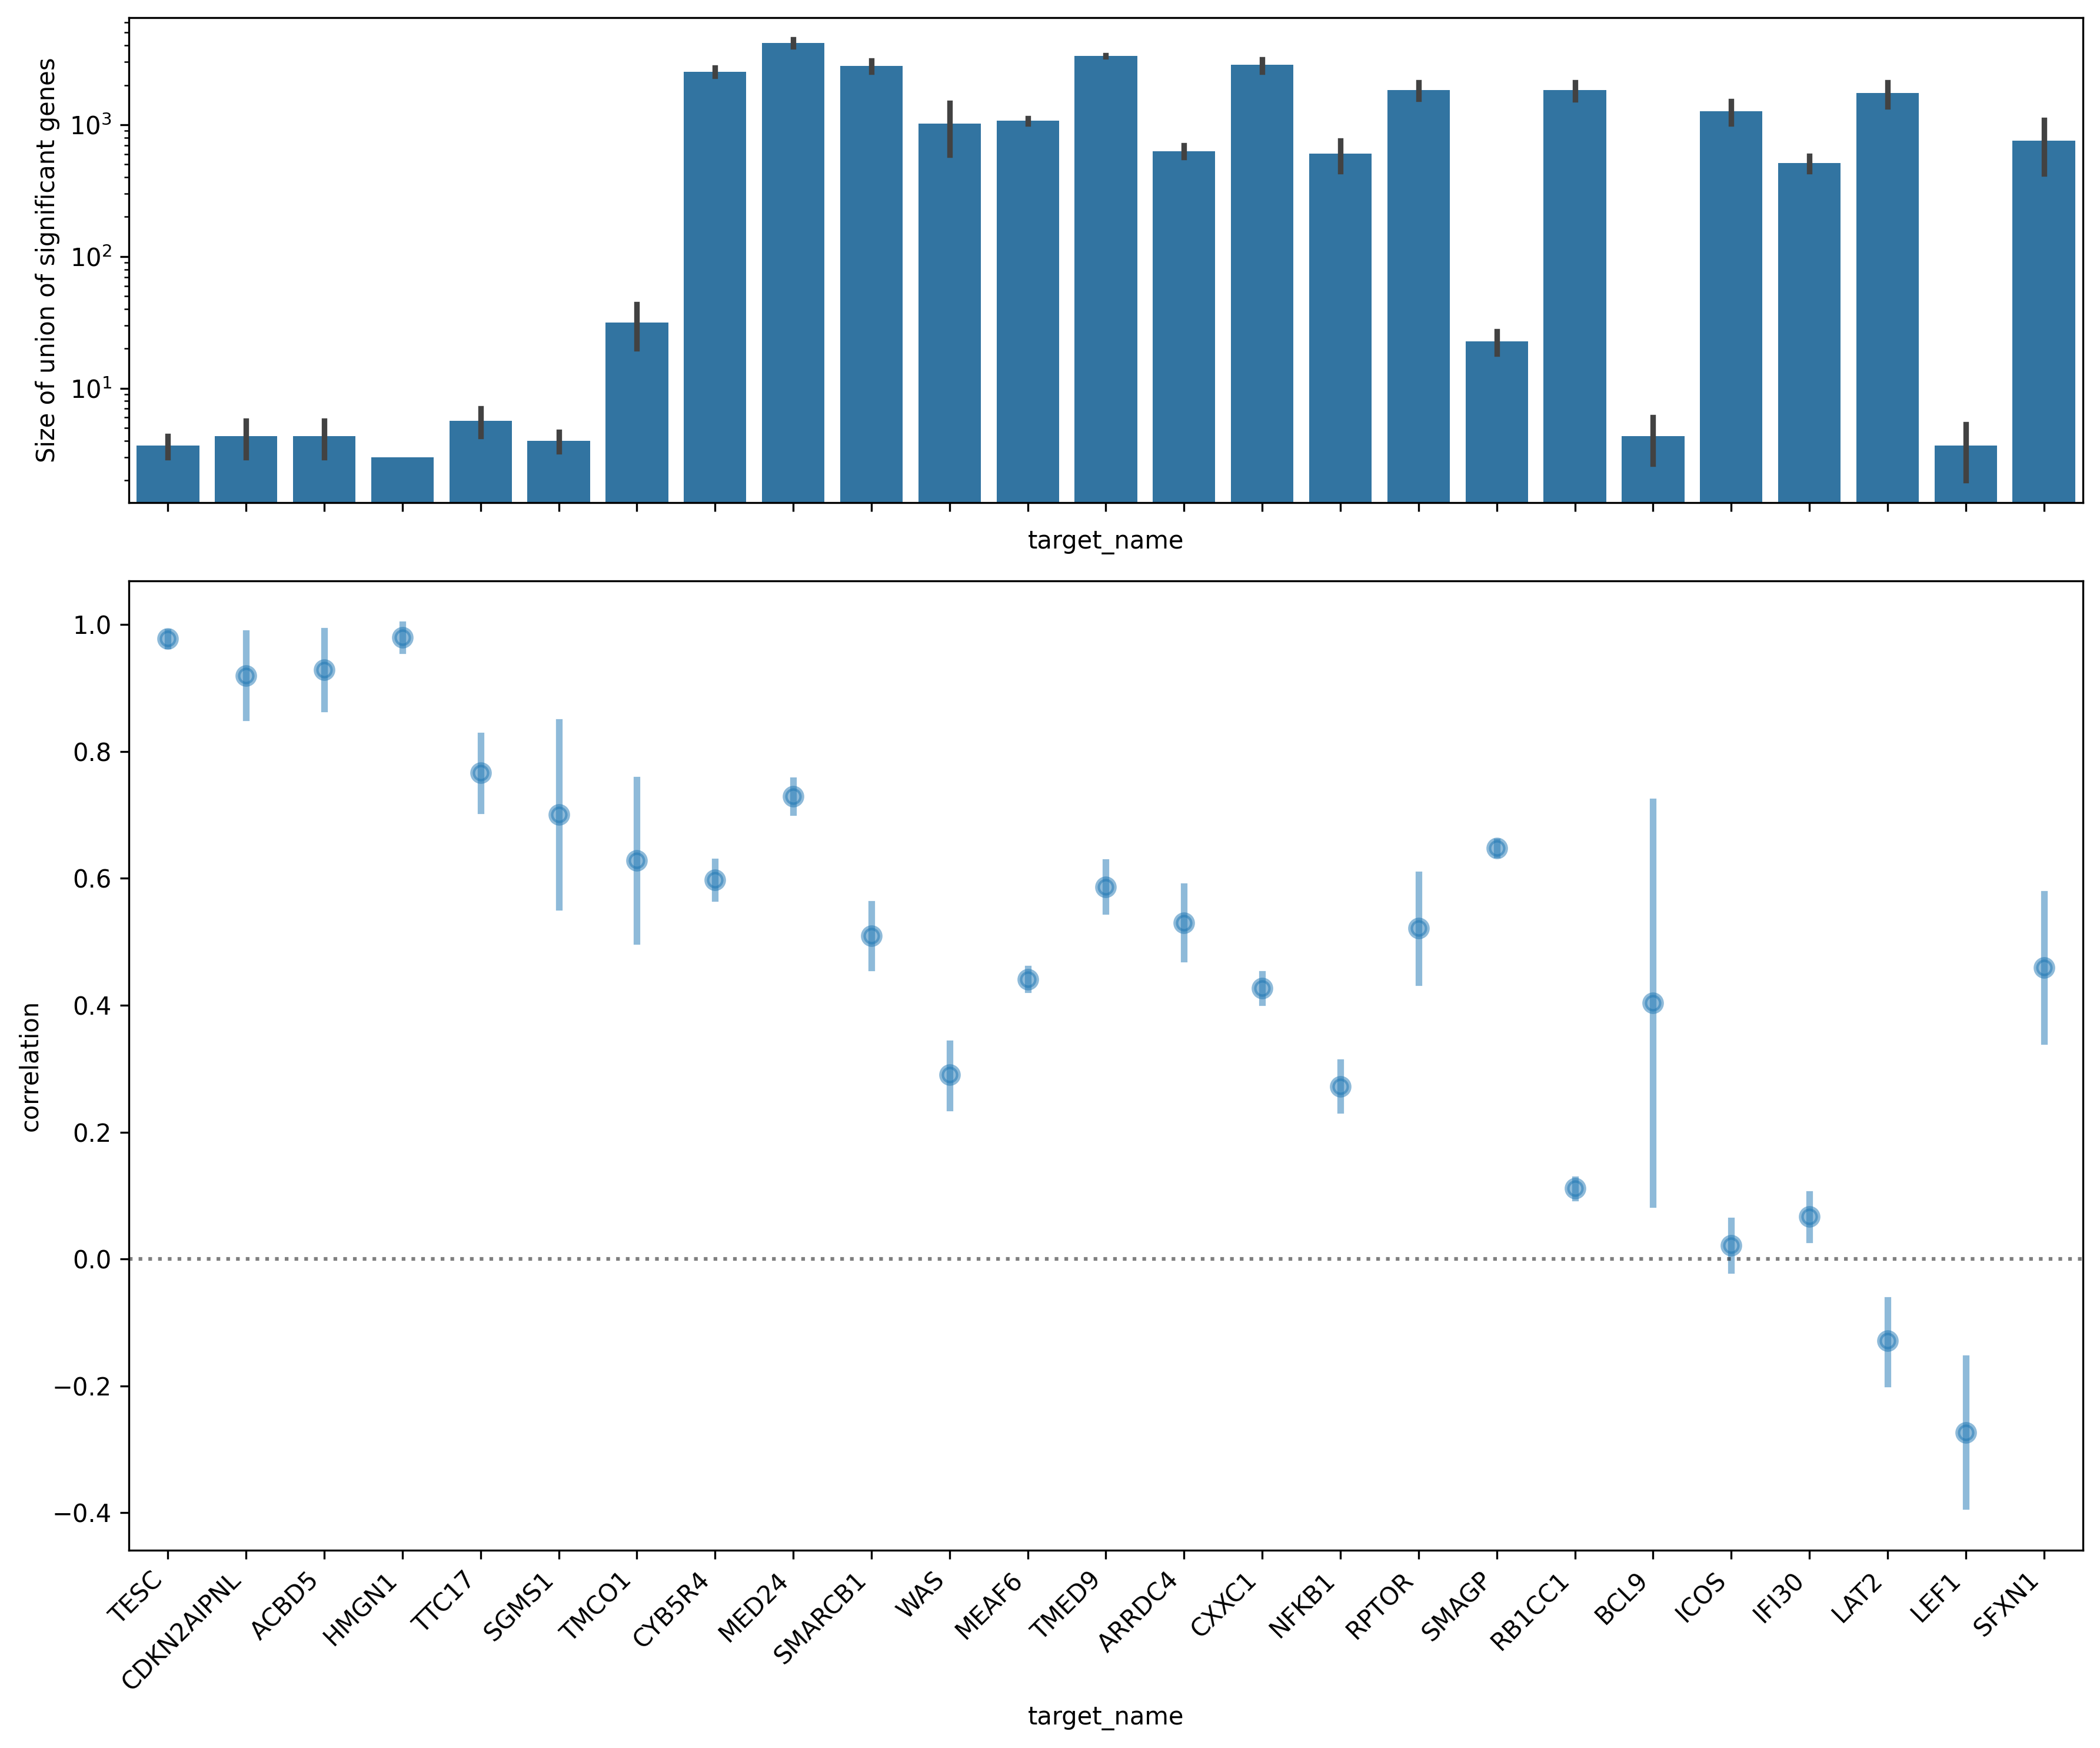

In [42]:
# # Calculate mean correlation per target to sort by
# mean_corr = correlations.groupby('target_name')['n_signif'].mean().sort_values(ascending=False)
# sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='')
# sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
#               order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)

# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

## Check consistency on specific genes

In [80]:
DE_test_vars = anndata.experimental.read_lazy(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad').var.to_dataframe()
all_results_df = pd.merge(all_results_df.rename({'variable':'gene_ids'}, axis=1), DE_test_vars, how='left')
all_results_df = pd.merge(all_results_df.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond][['target_contrast','target_name']], how='left')

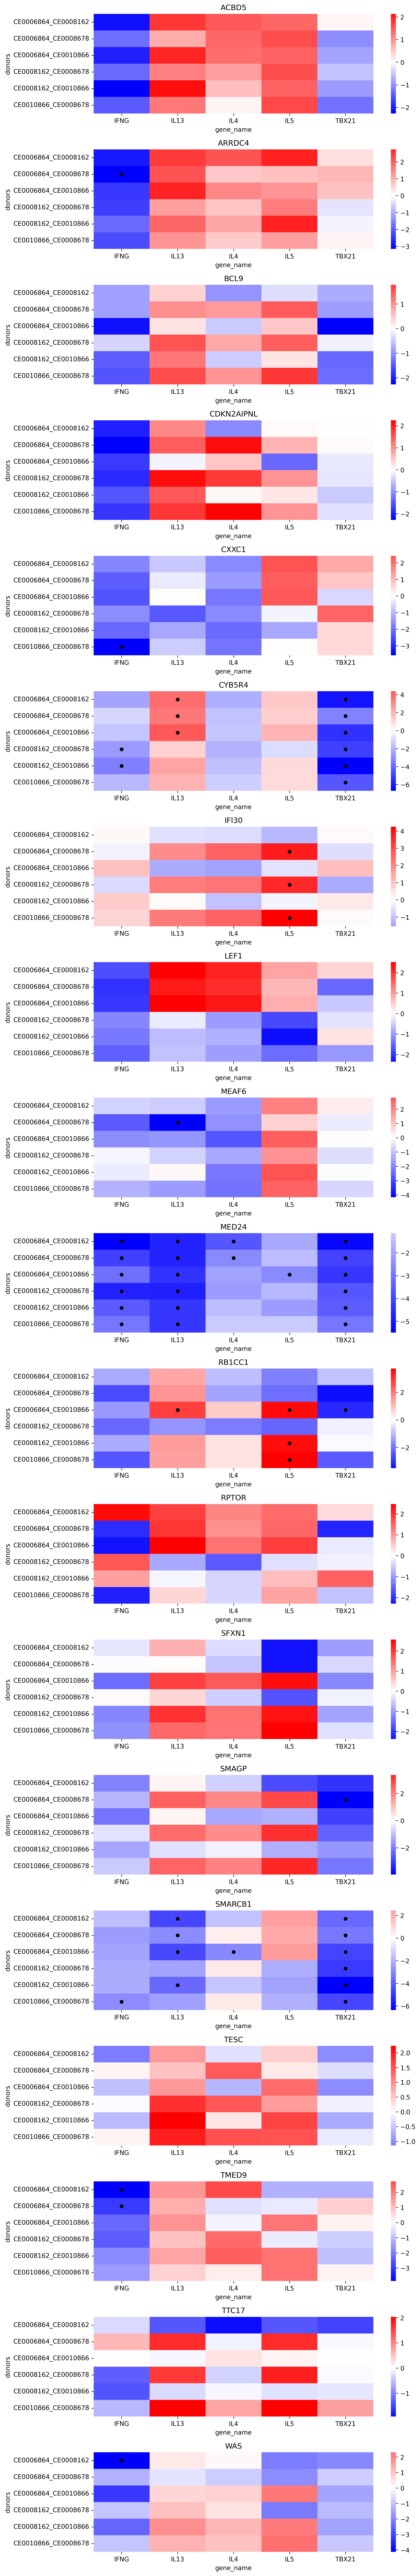

In [109]:
genes_oi = ['TBX21', 'IFNG', 'IL4', 'IL5', 'IL13']

pl_df = all_results_df[all_results_df['gene_name'].isin(genes_oi) & all_results_df.target_name.isin(Th2_regulators)]
signif_pl_df = pl_df.pivot(columns='gene_name', index=['target_name','donors'], values='adj_p_value')
signif_pl_df = signif_pl_df < 0.1
pl_df = pl_df.pivot(columns='gene_name', index=['target_name','donors'], values='zscore')

# Create a subplot for each target
targets = pl_df.index.get_level_values('target_name').unique()
fig, axes = plt.subplots(len(targets), 1, figsize=(10, 3*len(targets)))

for i, target in enumerate(targets):
    target_data = pl_df.loc[target]
    signif_data = signif_pl_df.loc[target]
    
    # Create heatmap
    sns.heatmap(target_data, cmap='bwr', center=0, 
                ax=axes[i], cbar=True)
    
    # Add dots for significant results
    for j, donor in enumerate(target_data.index):
        for k, gene in enumerate(target_data.columns):
            if signif_data.loc[donor, gene]:
                axes[i].plot(k + 0.5, j + 0.5, 'k.', markersize=10)
    
    axes[i].set_title(target)
    axes[i].set_xticklabels(target_data.columns)

plt.tight_layout()


## Compare estimates on all donors

In [26]:
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import *

In [20]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')


In [25]:
adata_de[adata_de.obs['target_contrast_gene_name'] == 'NEUROG2'].obs

target_contrast_gene_name culture_condition  \
ENSG00000178403_Stim8hr                    NEUROG2           Stim8hr   
ENSG00000178403_Rest                       NEUROG2              Rest   
ENSG00000178403_Stim48hr                   NEUROG2          Stim48hr   

                          target_contrast chunk  n_cells_target  
ENSG00000178403_Stim8hr   ENSG00000178403    70          1261.0  
ENSG00000178403_Rest      ENSG00000178403   484          1196.0  
ENSG00000178403_Stim48hr  ENSG00000178403   627          1293.0

In [29]:
t = 'NEUROG2'
DE_results = get_DE_results_long(
        adata_de,
        targets=[t], 
        effect_estimates = ['log_fc', 'lfcSE'],
        signif_estimate = 'adj_p_value',
        target_id_col = 'target_contrast_gene_name',
        gene_id_col='gene_name'
    )
DE_results = DE_results[DE_results['culture_condition'] == 'Stim8hr'].copy()
# DE_results = DE_results[DE_results['significant']]

In [30]:
DE_results

index             gene    log_fc     lfcSE  \
27918  ENSG00000178403_Stim8hr  ENSG00000000003  0.143627  5.310099   
27919  ENSG00000178403_Stim8hr  ENSG00000000419  0.010622  0.037350   
27920  ENSG00000178403_Stim8hr  ENSG00000000457  0.076317  0.083286   
27921  ENSG00000178403_Stim8hr  ENSG00000000460  0.063064  0.088724   
27922  ENSG00000178403_Stim8hr  ENSG00000000938  1.348444  1.143941   
...                        ...              ...       ...       ...   
41872  ENSG00000178403_Stim8hr  ENSG00000290292  0.043471  0.110714   
41873  ENSG00000178403_Stim8hr  ENSG00000290795       NaN       NaN   
41874  ENSG00000178403_Stim8hr  ENSG00000290797       NaN       NaN   
41875  ENSG00000178403_Stim8hr  ENSG00000291096       NaN       NaN   
41876  ENSG00000178403_Stim8hr  ENSG00000291237  0.011926  0.078448   

       adj_p_value  significant        gene_name culture_condition  \
27918     0.999815        False           TSPAN6           Stim8hr   
27919     0.999815        False             DPM1           Stim8hr   
27920     0.999815        False            SCYL3           Stim8hr   
27921     0.999815        False         C1orf112           Stim8hr   
27922     0.999815        False              FGR           Stim8hr   
...            ...          ...              ...               ...   
41872     0.999815        False            HOMEZ           Stim8hr   
41873          NaN        False          C2orf83           Stim8hr   
41874          NaN        False  ENSG00000290797           Stim8hr   
41875          NaN        False  ENSG00000291096           Stim8hr   
41876     0.999815        False             SOD2           Stim8hr   

       target_contrast target_contrast_gene_name  
27918  ENSG00000178403                   NEUROG2  
27919  ENSG00000178403                   NEUROG2  
27920  ENSG00000178403                   NEUROG2  
27921  ENSG00000178403                   NEUROG2  
27922  ENSG00000178403                   NEUROG2  
...                ...                       ...  
41872  ENSG00000178403                   NEUROG2  
41873  ENSG00000178403                   NEUROG2  
41874  ENSG00000178403                   NEUROG2  
41875  ENSG00000178403                   NEUROG2  
41876  ENSG00000178403                   NEUROG2  

[13959 rows x 10 columns]

In [164]:
# Get full results and split results
full_results = DE_results.set_index('gene')['log_fc']
split_results = all_results_df[all_results_df.target_name == t].pivot(columns='donors', index=['gene_ids'], values='log_fc')

# Find common genes between full and split results
common_genes = np.intersect1d(full_results.index, split_results.index.get_level_values('gene_ids'))

# Filter both dataframes to only include common genes
full_results_common = full_results.loc[common_genes]
split_results_common = split_results.loc[split_results.index.get_level_values('gene_ids').isin(common_genes)]
# Create figure and axes
n_pairs = split_results_common.shape[1]
n_cols = 2
n_rows = (n_pairs + 1) // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 8*n_rows))
axes = axes.flatten()

# Plot scatter for each donor pair
for i, donor_pair in enumerate(split_results_common.columns):
    # Plot scatter with seaborn
    sns.scatterplot(x=full_results_common, y=split_results_common.iloc[:, i], ax=axes[i])
    
    # Add diagonal line
    lims = [
        min(axes[i].get_xlim()[0], axes[i].get_ylim()[0]),
        max(axes[i].get_xlim()[1], axes[i].get_ylim()[1]),
    ]
    axes[i].plot(lims, lims, 'k--', alpha=0.5, zorder=0)
    
    # Set labels
    axes[i].set_xlabel('Log2 fold change (all donors)')
    axes[i].set_ylabel('Log2 fold change (donor pair)')
    
    # Set title
    axes[i].set_title(f'Comparison of DE results: All donors vs {donor_pair}')

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

## Th1 regulators

Using list curated by Ron

```bash
PERTURBS=$(tr '\n' ',' < th1regulators.txt | sed 's/,$//')
python get_donor_robustness.py --condition Stim8hr --target $PERTURBS
```

In [71]:
cond = 'Stim8hr'
Th1_regulators = pd.read_table('th1regulators.txt', header=None)[0].tolist()

parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*.parquet")
all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
all_results_df = all_results_df[all_results_df['culture_condition'] == cond]

In [72]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='log_fc')
pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_se = pivoted_se.loc[target]
    target_p = pivoted_pval.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            # Get mask for genes with p < 0.1 in either test
            sig_mask = (target_p[pair[0]] < 0.1) | (target_p[pair[1]] < 0.1)
            # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
            
            # Filter data using mask
            data1 = target_data[pair[0]][sig_mask]
            data2 = target_data[pair[1]][sig_mask]
            se1 = target_se[pair[0]][sig_mask]
            se2 = target_se[pair[1]][sig_mask]
            
            corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'correlation_ceiling': corr_ceil,
                'n_signif':data1.shape[0]
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
correlations = correlations[correlations.target_name.isin(Th1_regulators)]

/tmp/ipykernel_2251812/2298880084.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


/tmp/ipykernel_2251812/3072865098.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


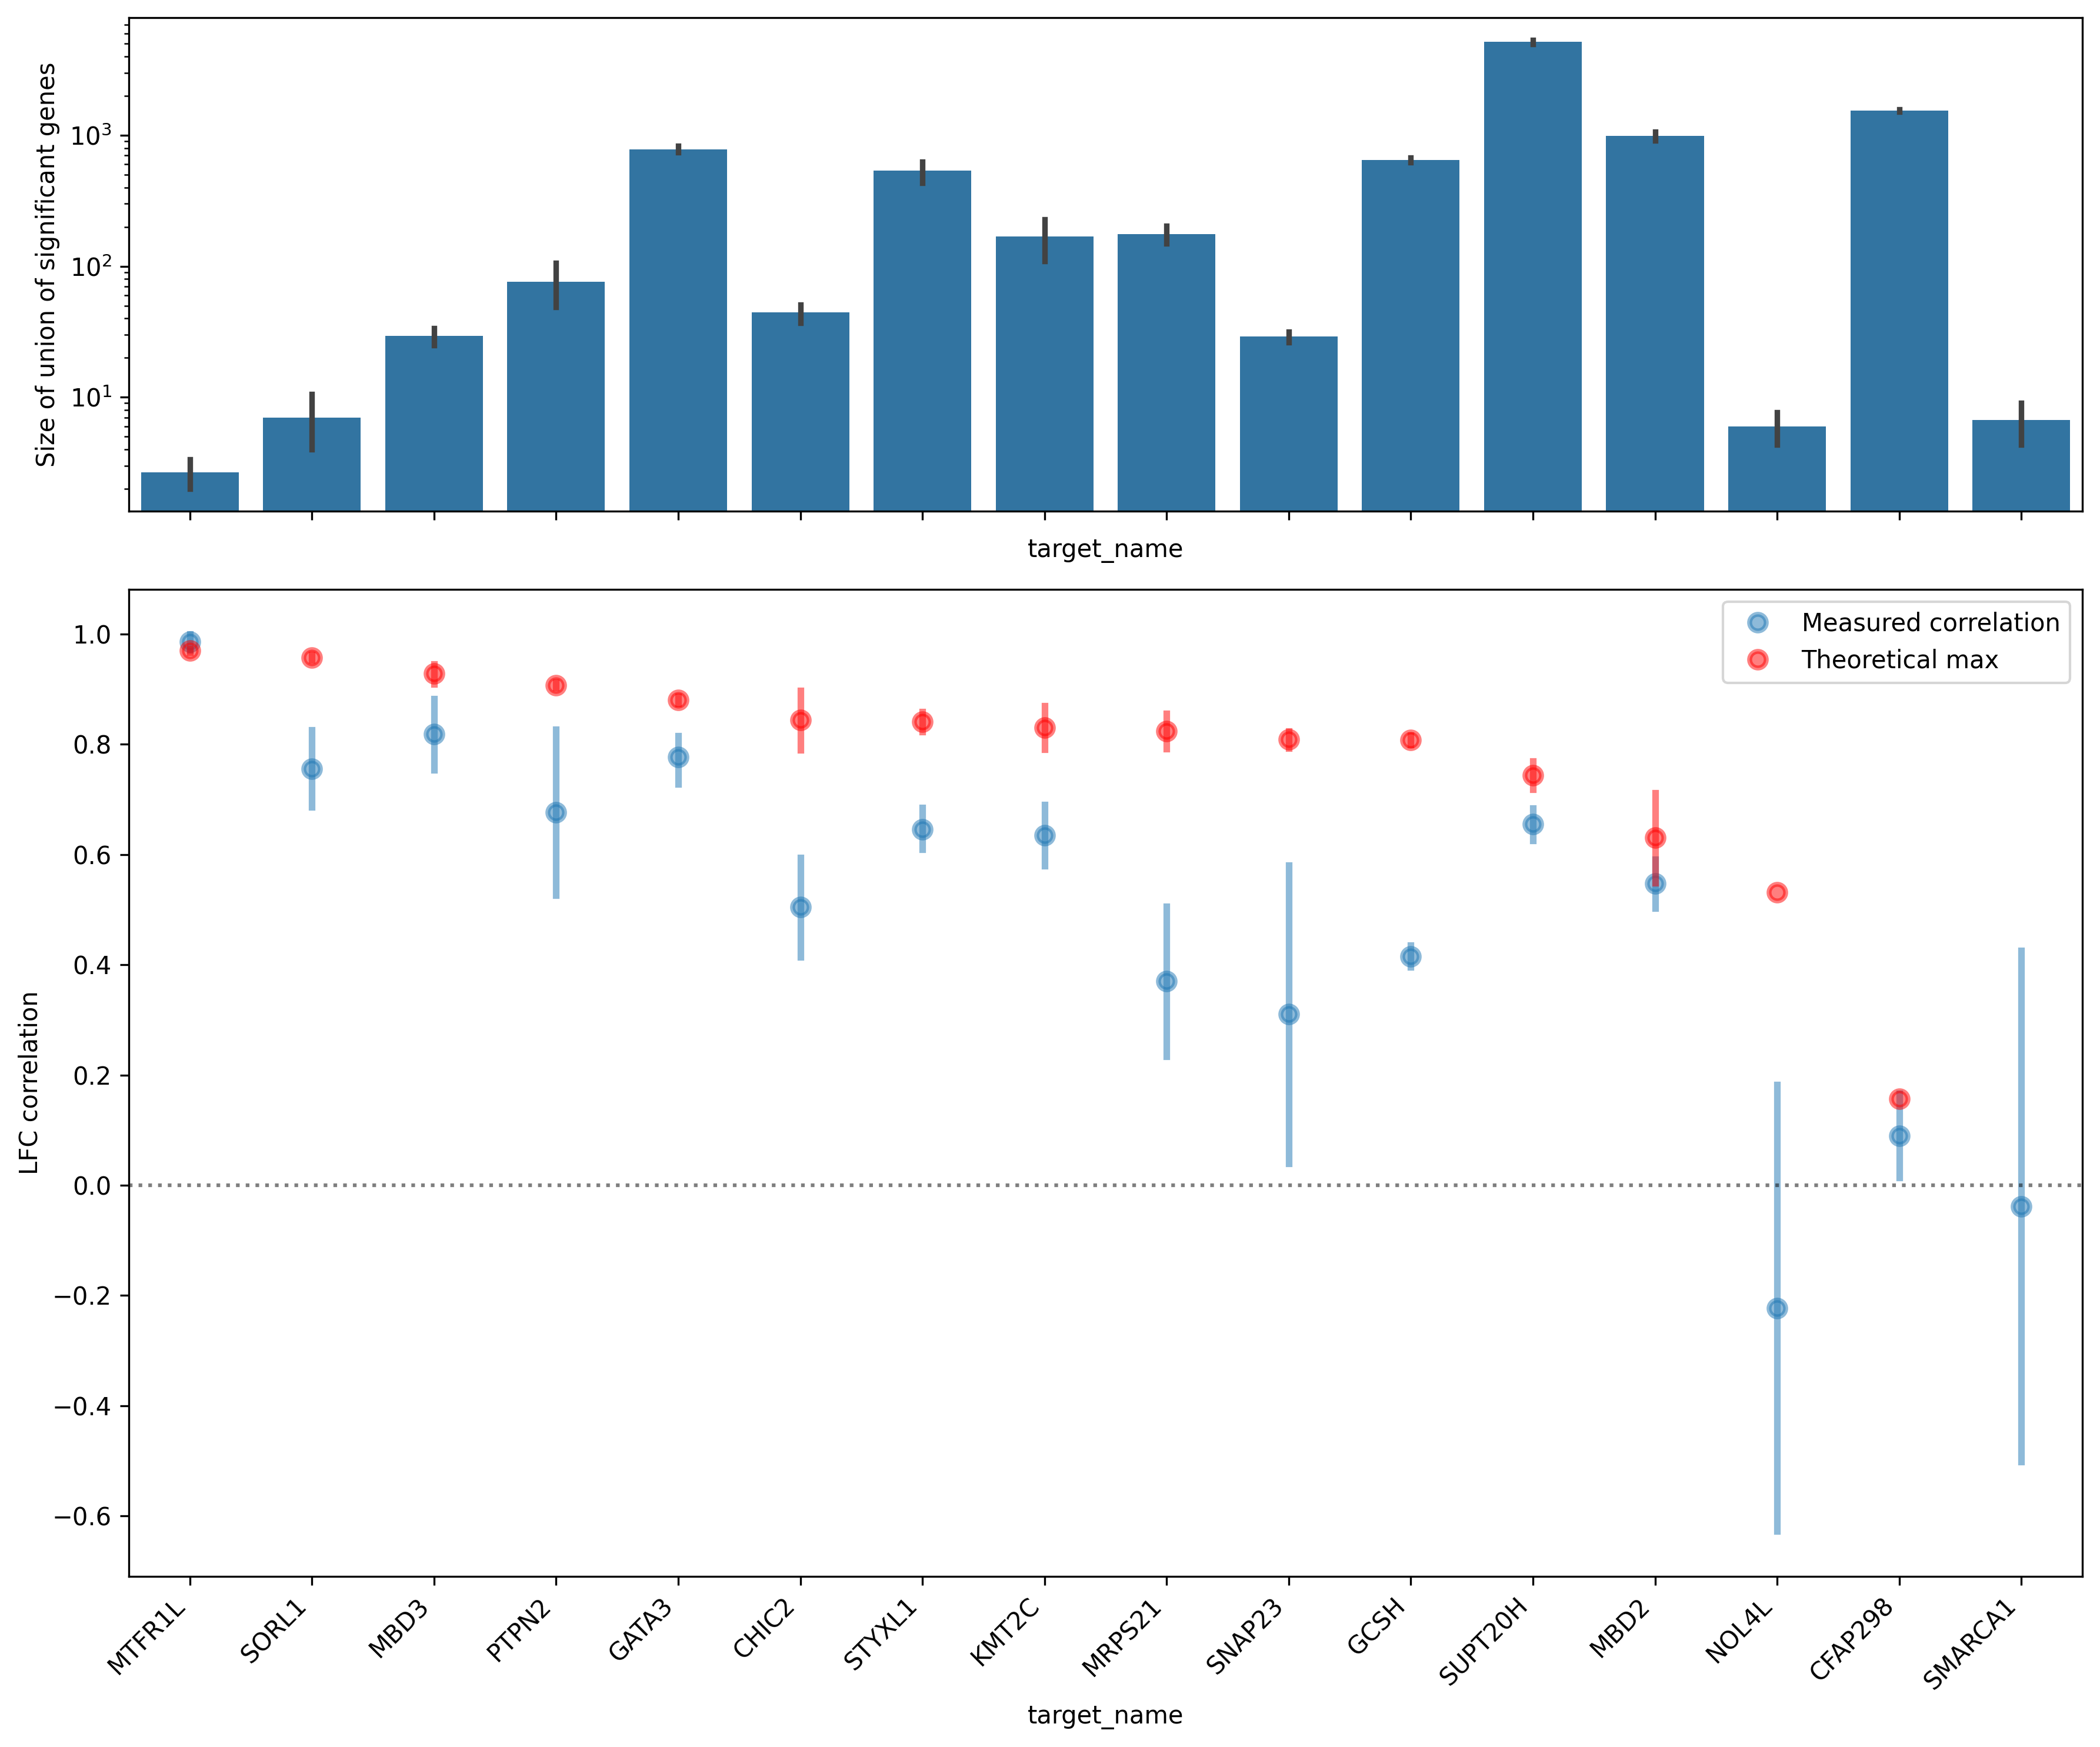

In [73]:
# Calculate mean correlation per target to sort by
mean_corr = correlations.groupby('target_name')['correlation_ceiling'].mean().sort_values(ascending=False)
sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='', label='Measured correlation')
sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
              order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='', label='Theoretical max')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)
ax2.set_ylabel('LFC correlation')
# Add legend inside plot
ax2.legend(bbox_to_anchor=(1, 1))


# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()